# Python Windrose with MesoWest Data
Brian Blaylock  
May 16, 2017

#### Introduction
1. Who are we?
    - http://meso1.chpc.utah.edu/mesowest_overview/
2. Introduction to api services:
    - What are the MesoWest/SynopticLabs api services?
        - https://synopticlabs.org/api/
    - How do you find out where particulate concentrations are measured in Utah?  
        - https://api.synopticlabs.org/v2/stations/latest?&token=demotoken&state=UT&vars=PM_25_concentration
        - http://meso2.chpc.utah.edu/aq/
3. Learning objectives:
    - Evaluate data from different sensor types.
    - Use an api service to access data in real time and retrospectively.
    - Visualize air quality data relative to wind conditions.

We will use Python to view air quality data from the MesoWest API.

But first...
1. Install the [JSON Viewer](https://chrome.google.com/webstore/detail/json-viewer/aimiinbnnkboelefkjlenlgimcabobli) for your Chrome browser. This will help you look at JSON-formated data in your browser.
2. Make sure you have `pm25rose.py` in the current directory. That package makes wind roses, you won't change anything in that file. (The original wind rose code is found [here](https://github.com/scls19fr/windrose)).

### Import some stuff we'll use

In [161]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from datetime import datetime
import json
import urllib2

# Confirm that `pm25rose.py` is in your directory
from pm25rose import WindroseAxes

 #### Customize matplotlib 
 It's so much easier to modify matplotlib defaults like this rather than inline with the plot functions.  
 See more here [http://matplotlib.org/users/customizing.html](http://matplotlib.org/users/customizing.html)

In [162]:
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [5, 10]
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['savefig.bbox'] = 'tight'

### Define a few functions

First function will get MesoWest data and return a Python dictionary.

Find a list of all available variables:
https://synopticlabs.org/api/mesonet/variables/

In [164]:
default_vars = 'altimeter,pressure,sea_level_pressure,wind_direction,\
wind_speed,air_temp,relative_humidity,dew_point_temperature,wind_gust'

def get_mesowest_ts(stationID, start_time, end_time, variables=default_vars):
    """
    Get MesoWest Time Series data:
    Makes a time series query from the MesoWest API for a single station.

    Input:
        stationID  : string of the station ID
        start_time : datetime object of the start time in UTC
        end_time   : datetime object of the end time in UTC
        variables  : a string of variables available through the MesoWest API
                     see https://synopticlabs.org/api/mesonet/variables/ for
                     a list of variables.
    Output:
        A dictionary of the data.
    """

    # Hey! You can get your own token! https://synopticlabs.org/api/guides/?getstarted
    token = 'demotoken'
    
    # Convert the start and end time to the string format requried by the API
    start = start_time.strftime("%Y%m%d%H%M")
    end = end_time.strftime("%Y%m%d%H%M")
    tz = 'utc'  # Timezone is hard coded for now. Could allow local time later.

    # Build the API request URL
    URL = 'http://api.mesowest.net/v2/stations/timeseries?&token=' + token \
        + '&stid=' + stationID \
        + '&start=' + start \
        + '&end=' + end \
        + '&vars=' + variables \
        + '&obtimezone=' + tz \
        + '&output=json'

    print "Here is the URL you asked for:", URL
        
    # Open URL and read JSON content. Convert JSON string to some python
    # readable format.
    f = urllib2.urlopen(URL)
    data = f.read()
    data = json.loads(data)

    # Create a new dictionary to store the data in.
    return_this = {}

    # Get basic station information
    return_this['URL'] = URL
    return_this['NAME'] = str(data['STATION'][0]['NAME'])
    return_this['STID'] = str(data['STATION'][0]['STID'])
    return_this['LAT'] = float(data['STATION'][0]['LATITUDE'])
    return_this['LON'] = float(data['STATION'][0]['LONGITUDE'])
    return_this['ELEVATION'] = float(data['STATION'][0]['ELEVATION'])
                               # Note: Elevation is in feet, NOT METERS!

    # Dynamically create keys in the dictionary for each requested variable
    for v in data['STATION'][0]['SENSOR_VARIABLES'].keys():
        if v == 'date_time':
            # Dates: Convert the strings to a python datetime object.
            dates = data["STATION"][0]["OBSERVATIONS"]["date_time"]
            DATES = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ') for x in dates]
            return_this['DATETIME'] = np.array(DATES)
        else:
            # v represents all the variables, but each variable may have
            # more than one set.
            # For now, just return the first set.
            key_name = str(v)
            set_num = 0

            grab_this_set = str(data['STATION'][0]['SENSOR_VARIABLES']\
                                [key_name].keys()[set_num])

            # Always grab the first set (either _1 or _1d)
            # ! Should make exceptions to this rule for certain stations and certain
            # ! variables (a project for another day :p).
            if grab_this_set[-1] != '1' and grab_this_set[-1] != 'd':
                grab_this_set = grab_this_set[0:-1]+'1'
            if grab_this_set[-1] == 'd':
                grab_this_set = grab_this_set[0:-2]+'1d'

            variable_data = np.array(data['STATION'][0]['OBSERVATIONS']\
                                    [grab_this_set], dtype=np.float)
            return_this[key_name] = variable_data

    return return_this

These two functions set up the windroses axes and legend

In [165]:
# Make Rose
#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax
#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    #plt.setp(l.get_texts())
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), prop={'size':10})

----------

## Ok, lets get some data

In [166]:
# Date range for data we are interested
start = datetime(2016, 12, 1)
end = datetime(2017, 3, 1)

In [167]:
# MesoWest station ID.
stn = 'MTMET'

Find other stations with PM 25 concentrations here:  
https://api.synopticlabs.org/v2/stations/metadata?&token=demotoken&state=UT&vars=PM_25_concentration&status=active

In [168]:
# Get MesoWest Data
a = get_mesowest_ts(stn, start, end, variables='wind_direction,PM_25_concentration')

Here is the URL you asked for: http://api.mesowest.net/v2/stations/timeseries?&token=demotoken&stid=MTMET&start=201612010000&end=201703010000&vars=wind_direction,PM_25_concentration&obtimezone=utc&output=json


### What is the variable `a`?

In [169]:
a

{'DATETIME': array([datetime.datetime(2016, 12, 1, 0, 0),
        datetime.datetime(2016, 12, 1, 0, 5),
        datetime.datetime(2016, 12, 1, 0, 10), ...,
        datetime.datetime(2017, 2, 28, 23, 50),
        datetime.datetime(2017, 2, 28, 23, 55),
        datetime.datetime(2017, 3, 1, 0, 0)], dtype=object),
 'ELEVATION': 4996.0,
 'LAT': 40.766573,
 'LON': -111.828211,
 'NAME': 'U of U Mountain Met Lab',
 'PM_25_concentration': array([ 3.,  3.,  3., ...,  0.,  0.,  0.]),
 'STID': 'MTMET',
 'URL': 'http://api.mesowest.net/v2/stations/timeseries?&token=demotoken&stid=MTMET&start=201612010000&end=201703010000&vars=wind_direction,PM_25_concentration&obtimezone=utc&output=json',
 'wind_direction': array([  82.  ,   76.15,   81.2 , ...,  335.7 ,  352.8 ,  353.1 ])}

`a` is a dictionary. Each key is associated with a value or object.

What data is in the dictionary?

In [170]:
a.keys()

['ELEVATION',
 'NAME',
 'URL',
 'STID',
 'LON',
 'DATETIME',
 'PM_25_concentration',
 'LAT',
 'wind_direction']

You can access the values or objects of each key like so...

In [171]:
print "Station Name:", a['NAME']
print "Number of Observations:", len(a['DATETIME'])
print "List of dates:", a['DATETIME']

Station Name: U of U Mountain Met Lab
Number of Observations: 25921
List of dates: [datetime.datetime(2016, 12, 1, 0, 0) datetime.datetime(2016, 12, 1, 0, 5)
 datetime.datetime(2016, 12, 1, 0, 10) ...,
 datetime.datetime(2017, 2, 28, 23, 50)
 datetime.datetime(2017, 2, 28, 23, 55) datetime.datetime(2017, 3, 1, 0, 0)]


----------

## Visualize the data
Each datetime object in `a['DATETIME']` matches PM 2.5 concentrations in `a['PM_25_concentration']` and wind directions in `a['wind_direction']`.
#### Plot a time series of PM 2.5 concentration for the time period

(0, 123.0)

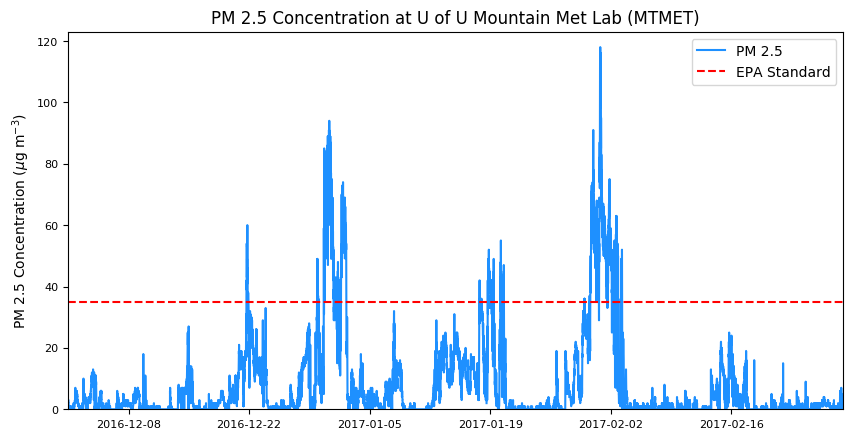

In [172]:
# Create a new figure
plt.figure(figsize=[10,5])

# Plot data lines
plt.plot(a['DATETIME'], a['PM_25_concentration'],
         color='dodgerblue',
         label="PM 2.5")
plt.axhline(35,
            linestyle = '--',
            color='r',
            label="EPA Standard")

# Add labels, etc.
plt.legend()
plt.ylabel(r'PM 2.5 Concentration ($\mu$g m$\mathregular{^{-3}}$)')
plt.title('PM 2.5 Concentration at %s (%s)' % (a['NAME'], a['STID']))
plt.xlim([a['DATETIME'][0], a['DATETIME'][-1]])
plt.ylim([0, np.nanmax(a['PM_25_concentration']+5)])

#### Plot a wind rose, to show how PM 2.5 is related to wind direction
`ax.bar()` is a function that makes wind roses. It requires two inputs:  
1. An array of wind directions.
2. An array of some variable related to wind direction, in this case PM 2.5.

The other inputs are not required, but allow us to custimize the figure.

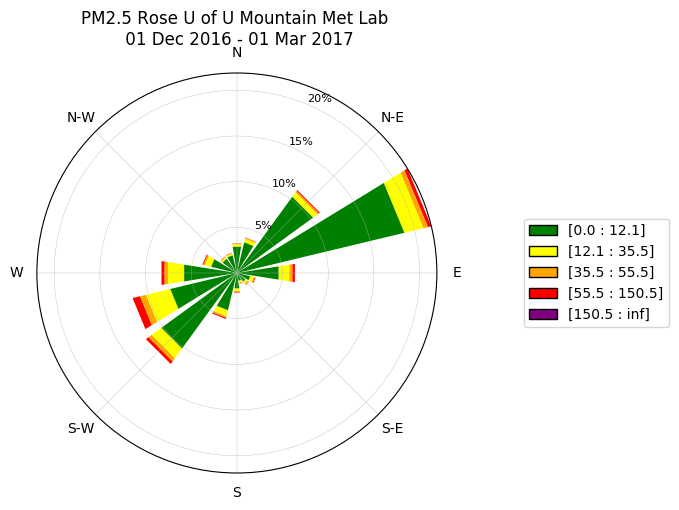

In [173]:
# Make the wind rose
ax = new_axes()
ax.bar(a['wind_direction'], a['PM_25_concentration'],
       nsector=16,
       normed=True,      # displays a normalized wind rose, in percent instead of count.
       bins=[0, 12.1, 35.5, 55.5, 150.5],
       colors=('green', 'yellow', 'orange', 'red', 'purple'))



# Create a legend
set_legend(ax)
plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%d %b %Y'), end.strftime('%d %b %Y')))

plt.grid(True)

# Grid at 5% intervals
plt.yticks(np.arange(5, 105, 5))
ax.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])

# Change the plot range
ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))
#ax.set_rmax(40)

#### Questions ???
- What does `ncestors` do? (Try increasing or decreasing it)
- How can you change the color of each bin? [Find matplotlib named colors here](http://matplotlib.org/examples/color/named_colors.html)
- How can you change the color range for each bin?
- How can you change the number of bins?
- What happens if you uncomment the last line `ax.set_rmax(40)`?

Instead of using the `ax.bar()` function, try `ax.contour()`, `ax.contourf()`, `ax.box()`

#### What does this data tell us?
- Where do winds typically blow from? Why?
- Do you know where MTMET station is?
    - Can you find the latitude and longitude for MTMET and find it's location in Google maps?
- From what direction did MTMET get the highest PM 2.5 pollution?
- How does this compare to the same time period last year?

--------

#### What data is used to make this plot? What did the `ax.bar()` function do?

In [174]:
# Values used to create the plot
ax._info["table"]

array([[  2.90401067,   3.4534181 ,  10.30923789,  18.85644769,
          4.61502237,   1.49517306,   1.14198258,   0.87905188,
          1.69139   ,   4.19904246,  10.20720509,   7.49941135,
          5.83941606,   2.89223766,   1.91900165,   1.98571541],
       [  0.25900636,   0.37673652,   0.58472647,   2.14268896,
          1.18907464,   0.40028255,   0.32964445,   0.21191429,
          0.27862805,   0.66713759,   1.31072914,   2.73918845,
          1.80127149,   0.70245664,   0.21583863,   0.18051958],
       [  0.06671376,   0.14520053,   0.20798995,   0.51016404,
          0.33749313,   0.13735186,   0.11773016,   0.07848677,
          0.14127619,   0.17659524,   0.43952594,   0.67498626,
          0.3649635 ,   0.16874657,   0.08633545,   0.08633545],
       [  0.03924339,   0.03139471,   0.12950318,   0.3845852 ,
          0.29040107,   0.08241111,   0.0510164 ,   0.04316773,
          0.05886508,   0.14912487,   0.35711483,   0.83195981,
          0.34926615,   0.11380582,  

#### Questions ???

In [175]:
print 'Why does it have this shape?', np.shape(ax._info["table"])
print 'Why is the last item all zeros?'

Why does it have this shape? (5L, 16L)
Why is the last item all zeros?


In [176]:
print 'The total frequency in each direction:', np.sum(ax._info["table"], axis=0)
print 'Maximum freqency (what we set rmax to)', np.max(np.sum(ax._info["table"], axis=0))

The total frequency in each direction: [  3.26897418   4.00674986  11.2314575   21.89388588   6.43199121
   2.11521859   1.6403736    1.21262067   2.17015933   5.19190016
  12.31457499  11.74554588   8.3549172    3.87724668   2.2486461
   2.29573817]
Maximum freqency (what we set rmax to) 21.8938858802


----------------------

## What if we only want a wind rose when PM 2.5 was high?

In [177]:
# Find where a['PM_25_concentration'] is high
high_PM_idx = a['PM_25_concentration'] > 35.5

# Note: You'll get a warning becuase there may be nans in the data

C:\Users\u0553130\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [178]:
# What did we just do? This variable contains a True/False for every position
high_PM_idx

array([False, False, False, ..., False, False, False], dtype=bool)

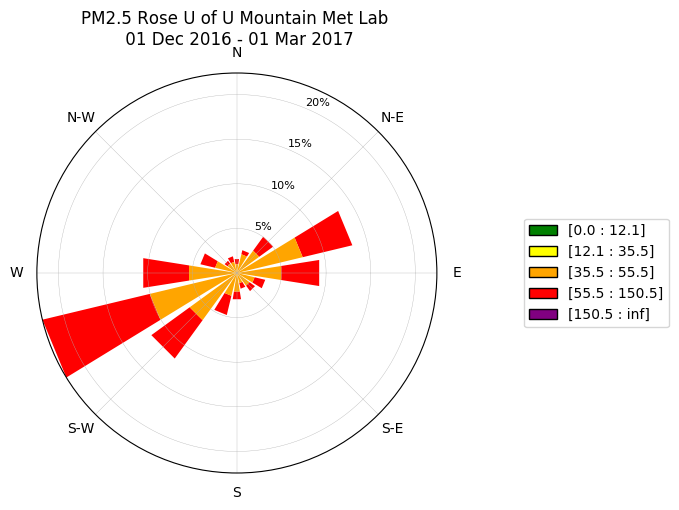

In [180]:
# Only get the dates and data when high_PM_idx is true.
direction_highPM = a['wind_direction'][high_PM_idx]
PM25_highPM = a['PM_25_concentration'][high_PM_idx]

# Create a new figure axis
axH = new_axes()
axH.bar(direction_highPM, PM25_highPM,
            nsector=16,
            normed=True,
            bins=[0, 12.1, 35.5, 55.5, 150.5],
            colors=('green', 'yellow', 'orange', 'red', 'purple'))

# Create a legend
set_legend(axH)
plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%d %b %Y'), end.strftime('%d %b %Y')))

plt.grid(True)

# Grid at 5% intervals
plt.yticks(np.arange(5, 105, 5))
axH.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])

# Change the plot range
axH.set_rmax(np.max(np.sum(axH._info['table'], axis=0)))

---

### How would you make a wind rose for another variable?
First, we need to get another variable from the MesoWest API. Lets try air temperature and wind speed.

In [181]:
a1 = get_mesowest_ts(stn, start, end, variables='wind_direction,air_temp,wind_speed')

Here is the URL you asked for: http://api.mesowest.net/v2/stations/timeseries?&token=demotoken&stid=MTMET&start=201612010000&end=201703010000&vars=wind_direction,air_temp,wind_speed&obtimezone=utc&output=json


In [182]:
# These are the availalbe keys
print a1.keys()

['wind_speed', 'air_temp', 'ELEVATION', 'NAME', 'URL', 'STID', 'LON', 'DATETIME', 'LAT', 'wind_direction']


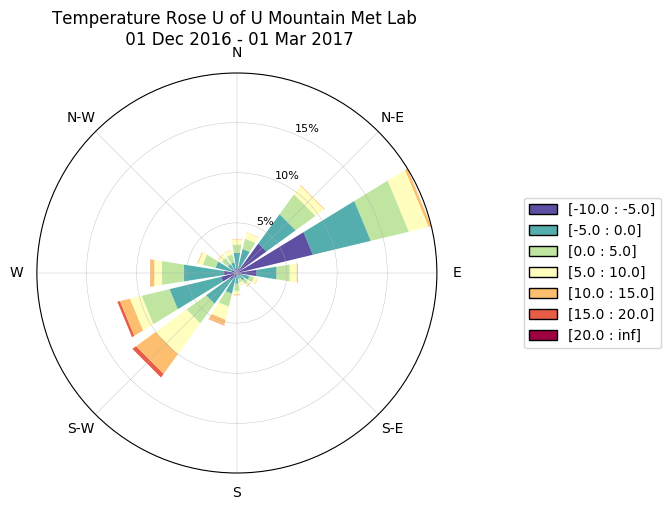

In [183]:
# Make a wind rose for air temperature
ax1 = new_axes()
ax1.bar(a1['wind_direction'], a1['air_temp'],
       nsector=16,
       normed=True,
       bins=range(-10,25,5),
       cmap=cm.Spectral_r)    # For a lit of other colormap options type: dir(cm)

# Add a legend and title
set_legend(ax1)
plt.title("Temperature Rose %s \n %s - %s" % (a['NAME'], start.strftime('%d %b %Y'), end.strftime('%d %b %Y')))

# Add the grid lines
plt.grid(True)

# Grid at 5% intervals, between 5 and 100
plt.yticks(np.arange(5, 105, 5))

# Label each grid with a % sign
ax1.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])

# Change the plot range
#ax.set_rmax(25)
ax1.set_rmax(np.max(np.sum(ax1._info['table'], axis=0)))

#### Question ???
- Can you tell where the wind typically blows at night, when it's cold?
- Can you make a rose for another time of year? Another station?

#### Wind Rose, in m/s

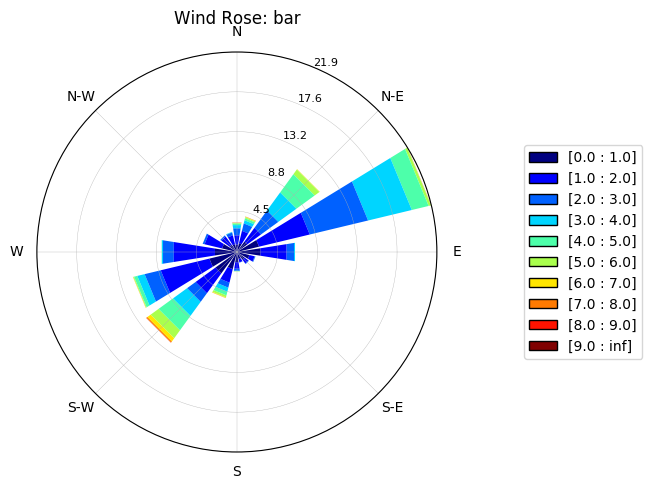

In [184]:
ax2 = new_axes()
ax2.bar(a1['wind_direction'], a1['wind_speed'],
       nsector=16,
       normed=True,
       bins=range(0,10))
set_legend(ax2)
ax2.set_title('Wind Rose: bar')

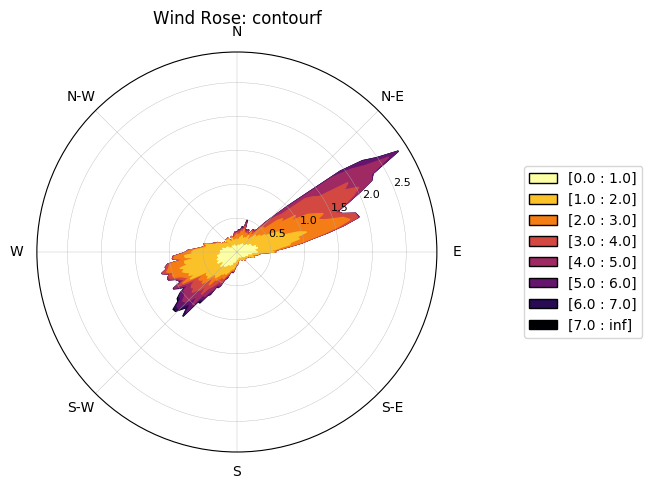

In [185]:
ax3 = new_axes()
ax3.contourf(a1['wind_direction'], a1['wind_speed'],
             nsector=180,
             normed=True,
             bins=range(0,8),
             cmap=cm.inferno_r)
ax3.set_title('Wind Rose: contourf')
set_legend(ax3)